In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import geopandas as gpd
import geoplot
import geoplot.crs as gcrs
from shapely.geometry import Point
from geopy import distance

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model


import warnings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
scaler = StandardScaler()

In [172]:
clean_data = pd.read_csv('data/Ames_HousePrice_cleaned.csv')
address_data = pd.read_csv('data/Ames_HousePrice_Address.csv')

clean_data = clean_data.merge(address_data[['PID', 'Longitude', 'Latitude']], on = 'PID')
clean_data = clean_data[~clean_data['Longitude'].isna()].copy()
clean_data = clean_data[clean_data['PID']!=908154205]
clean_data_cluster = clean_data[['Longitude', 'Latitude']]

mainlocs = {"LincolnGrand" : (42.0228613,-93.6202381),
            "LincolnSD" : (42.0229155,-93.6786829),
            "OntarioND" : (42.034549,-93.6787169),
            "Grand13" : (42.0345358,-93.6203941),
            "Grand24" : (42.0457363,-93.6205019),
            "GWHarrison" : (42.0594753,-93.6592406),
            "BloomStange" : (42.0563395,-93.6448835),
            "IC3069" : (42.0049608,-93.609927)}

for kw, val in mainlocs.items():
    clean_data['dist_%s' %kw] = clean_data.apply(lambda x: distance.distance((x.loc['Latitude'],x.loc['Longitude']), val).miles, axis = 1)
    clean_data['gaudist_%s' %kw] = clean_data.apply(lambda x: np.exp(-x['dist_%s' %kw]**2), axis = 1)
    # clean_data['gaudist2_%s' %kw] = clean_data.apply(lambda x: np.exp(-x['dist_%s' %kw]**4), axis = 1)

In [173]:
# scaled_features = scaler.fit_transform(clean_data_cluster)
# kmeans = KMeans(init="random", n_clusters=10, n_init=10, max_iter=300, random_state=42)
# kmeans.fit(scaled_features)
# clean_data['cluster'] = kmeans.labels_
# clean_data.to_csv('x_new.csv',index=False)

In [174]:
clean_data = clean_data[~clean_data['Longitude'].isna()]
cl_y = clean_data['SalePrice']
cl_x = clean_data.drop(['PID','SalePrice','LandContour','PavedDrive'], axis = 1)

cl_x_dummies = pd.get_dummies(cl_x, columns=['MSSubClass','MSZoning','LotShape',\
        'LotConfig', 'Neighborhood', 'BldgType', 'HouseStyle','MasVnrType', 'ExterQual', \
        'ExterCond', 'Foundation', 'BsmtQual','BsmtCond', 'BsmtExposure', 'BsmtFinType1','BsmtFinType2',
       'HeatingQC','CentralAir','KitchenQual','GarageType','SaleCondition','Electrical'],\
        prefix=['mssc','msz','ls',\
                'lcf','nghbr','bt','hs','mvt','eq',\
                'ec','f','bq','bc','be','bf1','bf2',\
               'hq','ca','kq','gt','sc','el'], prefix_sep='_',drop_first=True)
               
cl_x_dummies = cl_x_dummies.fillna(0)

# print(cl_x_dummies.shape)
# print(cl_y.shape)
trainscore = []
testscore = []

for i in range(500):
        X_train, X_test, y_train, y_test = train_test_split(cl_x_dummies, cl_y, test_size=0.3, random_state=i, shuffle=True)
        # X_train.to_csv('x_train_dummies.csv',index=False)
        # y_train.to_csv('y_train_dummies.csv',index=False)
        # X_test.to_csv('x_test_dummies.csv',index=False)
        # y_test.to_csv('y_test_dummies.csv',index=False)

        scaler.fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled  = scaler.transform(X_test)

        model  = linear_model.RidgeCV(alphas=np.logspace(-3, 3, 7))
        model.set_params(normalize=True)
        model.fit(X_train, y_train)

        trainscore.append(model.score(X_train, y_train))
        testscore.append(model.score(X_test, y_test))
        
        coefs  = model.coef_.T
        beta = list(zip(X_train.columns.to_list(), coefs))

avetrainscore = np.mean(trainscore)
avetestscore = np.mean(testscore)



In [175]:
clean_data['residual'] = cl_y - model.predict(cl_x_dummies)
clean_data.sort_values('residual')

,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotArea,LotShape,LandContour,LotConfig,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,TotalBsmtSF,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,FullBath,BedroomAbvGr,KitchenQual,Fireplaces,GarageType,GarageArea,PavedDrive,OurdoorSpace,MoSold,YrSold,YrMoSold,AgeSold,SaleCondition,Longitude,Latitude,dist_LincolnGrand,gaudist_LincolnGrand,dist_LincolnSD,gaudist_LincolnSD,dist_OntarioND,gaudist_OntarioND,dist_Grand13,gaudist_Grand13,dist_Grand24,gaudist_Grand24,dist_GWHarrison,gaudist_GWHarrison,dist_BloomStange,gaudist_BloomStange,dist_IC3069,gaudist_IC3069,residual
274,533350090,2944,150000,60,RL,24572,IR1,Lvl,CulDSac,Veenker,1Fam,2Story,9,3,1977,1977,BrkFace,1050.0,Gd,Gd,CBlock,Gd,TA,No,GLQ,410.0,Unf,0.0,994.0,TA,Y,SBrkr,1599,1345,2,3,Gd,1,Attchd,864.0,Y,226,6,2008,2008.500000,31.500000,Family,-93.655582,42.036729,2.055171,0.014644,1.523796,9.808186e-02,1.199816,0.237032,1.816817,0.036853,1.908862,0.026154,1.581153,0.082081,1.461103,0.118266,3.213724,3.270374e-05,-134175.283318
510,528108020,2042,253293,20,RL,12704,Reg,Lvl,Inside,NridgHt,1Fam,1Story,8,5,2008,2009,BrkFace,306.0,Ex,TA,PConc,Ex,TA,No,Unf,0.0,Unf,0.0,2042.0,Ex,Y,SBrkr,2042,0,2,3,Ex,1,Attchd,1390.0,Y,90,8,2009,2009.666667,0.666667,Partial,-93.654144,42.062992,3.273261,0.000022,3.040488,9.663550e-05,2.334865,0.004289,2.621359,0.001037,2.100683,0.012120,0.357242,0.880186,0.661567,0.645538,4.606287,6.098072e-10,-121091.821856
1730,535125010,2207,180000,20,RL,19900,Reg,Lvl,Inside,NAmes,1Fam,1Story,7,5,1970,1989,BrkFace,287.0,TA,TA,CBlock,Gd,TA,Gd,GLQ,912.0,Unf,0.0,1947.0,TA,Y,SBrkr,2207,0,2,3,TA,1,Attchd,576.0,Y,301,7,2010,2010.583333,21.583333,Normal,-93.614307,42.049514,1.864662,0.030901,3.786972,5.911721e-07,3.470944,0.000006,1.080162,0.311377,0.411751,0.844054,2.411343,0.002984,1.641840,0.067499,3.083225,7.438346e-05,-85194.693694
179,527326040,1411,82500,20,RL,11900,Reg,Lvl,Inside,NWAmes,1Fam,1Story,7,5,1977,1977,BrkFace,209.0,TA,Gd,CBlock,TA,TA,No,ALQ,822.0,Unf,0.0,1386.0,TA,Y,SBrkr,1411,0,2,3,TA,1,Attchd,544.0,Y,192,4,2009,2009.333333,32.333333,Family,-93.635056,42.055081,2.350801,0.003981,3.156992,4.694202e-05,2.655793,0.000865,1.606128,0.075801,0.988167,0.376637,1.280371,0.194106,0.512897,0.768693,3.692976,1.194151e-06,-76112.227271
2034,526355170,2223,244000,20,RL,13651,IR1,Lvl,Inside,NAmes,1Fam,1Story,7,6,1973,1973,BrkFace,1115.0,TA,Gd,CBlock,Gd,TA,Gd,ALQ,1880.0,Unf,0.0,2223.0,Ex,Y,SBrkr,2223,0,2,3,TA,2,Attchd,516.0,Y,300,2,2007,2007.166667,34.166667,Normal,-93.617273,42.049671,1.856635,0.031838,3.659697,1.525206e-06,3.328952,0.000015,1.056874,0.327266,0.318337,0.903627,2.262263,0.005989,1.492952,0.107646,3.108879,6.345807e-05,-75966.283183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1634,528110020,2674,610000,20,RL,13693,Reg,Lvl,Inside,NridgHt,1Fam,1Story,10,5,2007,2007,Stone,472.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,2288.0,Unf,0.0,2630.0,Ex,Y,SBrkr,2674,0,2,2,Ex,2,Attchd,762.0,Y,410,3,2009,2009.250000,2.250000,Normal,-93.657835,42.062789,3.366801,0.000012,2.953620,1.626568e-04,2.225492,0.007063,2.740810,0.000546,2.252292,0.006265,0.239860,0.944091,0.801175,0.526302,4.691065,2.772522e-10,122402.622577
1322,528320060,3627,625000,60,RL,35760,IR1,Lvl,CulDSac,NoRidge,1Fam,2Story,10,5,1995,1996,BrkFace,1378.0,Gd,Gd,PConc,Ex,TA,Gd,GLQ,1387.0,Unf,0.0,1930.0,Ex,Y,SBrkr,1831,1796,3,4,Gd,1,Attchd,807.0,Y,437,7,2006,2006.583333,10.583333,Normal,-93.657851,42.053314,2.857011,0.000285,2.355968,3.885181e-03,1.682163,0.059032,2.322289,0.004548,1.991192,0.018971,0.431208,0.830323,0.698930,0.613544,4.149533,3.326949e-08,124149.961515
582,528150070,2364,611

In [176]:
np.arange(0.8,0.95,0.005)

array([0.8  , 0.805, 0.81 , 0.815, 0.82 , 0.825, 0.83 , 0.835, 0.84 ,
       0.845, 0.85 , 0.855, 0.86 , 0.865, 0.87 , 0.875, 0.88 , 0.885,
       0.89 , 0.895, 0.9  , 0.905, 0.91 , 0.915, 0.92 , 0.925, 0.93 ,
       0.935, 0.94 , 0.945])

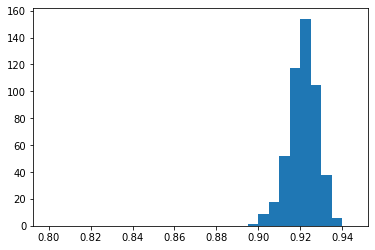

In [177]:
plt.hist(testscore, bins = np.arange(0.8,0.95,0.005))
plt.savefig("testscore_without_outlier.svg")

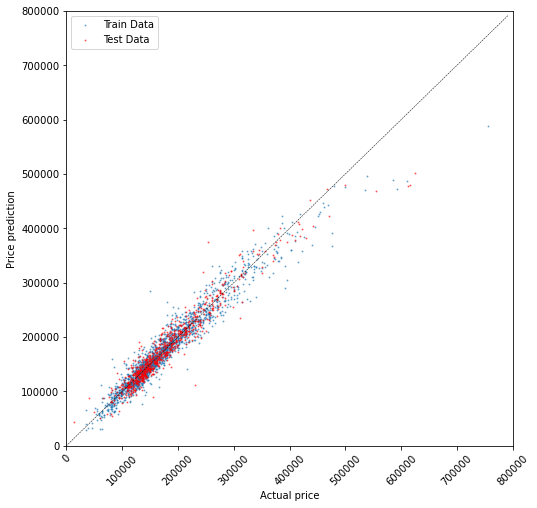

In [188]:
def abline(slope, intercept, ax):
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    ax.plot(x_vals, y_vals, 'k--', linewidth=0.5)

fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(y_train,model.predict(X_train), alpha = 0.5, s = 1, label='Train Data')
ax.scatter(y_test,model.predict(X_test), alpha = 0.5, s = 1, color = 'red', label='Test Data')
abline(1,0,ax)
plt.xlim([0, 800000])
plt.ylim([0, 800000])
plt.xlabel('Actual price')
plt.ylabel('Price prediction')
plt.xticks(rotation = 45)
leg = ax.legend()

plt.show()

fig.savefig("predictresult.svg")

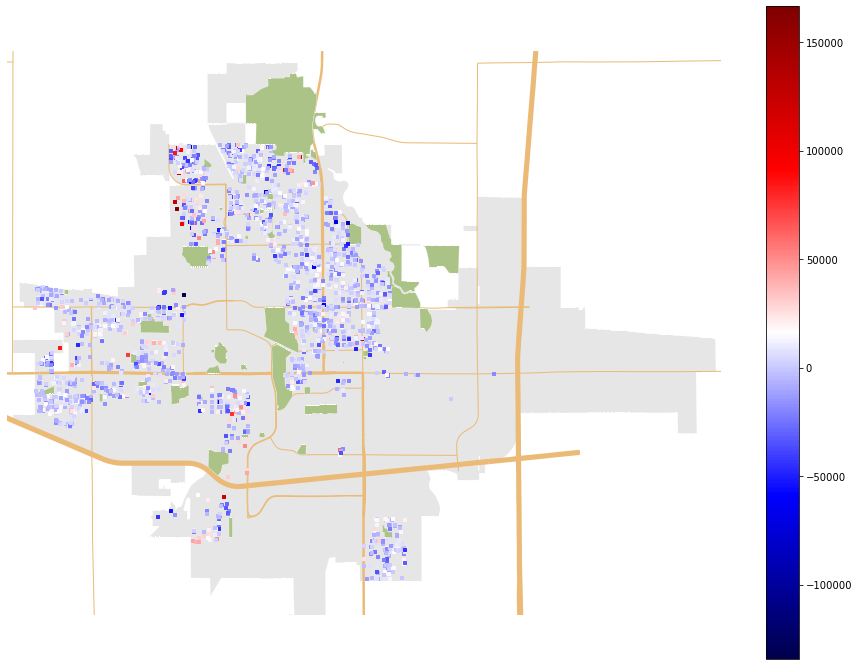

In [218]:
housing = clean_data
city = gpd.read_file("data/city.geojson")
roads = gpd.read_file("data/roads.geojson")
park = gpd.read_file("data/park.geojson")
houses = housing.apply(
    lambda srs: Point(float(srs['Longitude']), float(srs['Latitude'])),
    axis='columns'
)
roads_df = roads[['highway','geometry']]
roads_motor = roads_df[roads_df['highway']=='motorway']
roads_primary = roads_df[roads_df['highway']=='primary']
roads_secondary = roads_df[roads_df['highway']=='secondary']
# roads_tertiary = roads_df[roads_df['highway']=='tertiary']
# roads_residential = roads_df[roads_df['highway']=='residential']
housing['pps'] = housing['SalePrice']/housing['GrLivArea']
houses_geocode = gpd.GeoDataFrame(housing, geometry=houses)

ax = geoplot.polyplot(city, projection=gcrs.AlbersEqualArea(), edgecolor='white', facecolor='#e6e6e6', linewidth=.3, figsize=(16, 12))
geoplot.polyplot(roads_motor, edgecolor='#ebba76', linewidth=4, ax = ax)
geoplot.polyplot(roads_primary, edgecolor='#ebba76', linewidth=2.5, ax = ax)
geoplot.polyplot(roads_secondary, edgecolor='#ebba76', linewidth=1, ax = ax)
# geoplot.polyplot(roads_tertiary, edgecolor='white', linewidth=1, ax = ax)
# geoplot.polyplot(roads_residential, edgecolor='white', linewidth=0.25, ax = ax)
geoplot.pointplot(houses_geocode, hue='residual',cmap = 'seismic',\
     marker = 's', s = 3, alpha = 1, legend=True, ax=ax)
# geoplot.pointplot(houses_geocode, hue='sigdist_Grand24',cmap = 'cool', marker = '.', s = 5, legend=True, ax=ax)
geoplot.polyplot(park, projection=gcrs.AlbersEqualArea(), edgecolor='white', facecolor='#acc388', linewidth=.3, ax=ax, extent=( -93.70,41.98, -93.52, 42.08))

plt.savefig("residual.svg")

In [79]:
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D

xmin, xmax, nx = -93.70, -93.52, 200
ymin, ymax, ny = 41.98, 42.08, 200

x, y = np.linspace(xmin, xmax, nx), np.linspace(ymin, ymax, ny)
X, Y = np.meshgrid(x, y)

def gaussian(x, y, x0, y0, xalpha, yalpha, A):
    return A * np.exp( -((x-x0)/xalpha)**2 -((y-y0)/yalpha)**2)

